In [1]:
import numpy as np 
import cv2
import PIL
from tools import display_inline, display_multiple_inline, scaler

In [2]:
# import sys
# np.set_printoptions(threshold=sys.maxsize)

In [3]:
path = 'example.jpg'
img = cv2.imread(path)
img = scaler(img, 3)

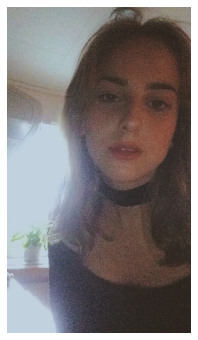

In [4]:
display_inline(img)

#### **Задание 1. Сравнение различных методов сглаживания**
1. Считать изображение с ярко выраженным шумом (например, шум «соль и перец» и/или гауссовский шум).  
2. Применить последовательно три фильтра сглаживания: **Box Blur**, **Gaussian Blur** и **Median Blur**.  
3. Для каждого результата визуально оценить, насколько хорошо удалён шум и сохранены детали. Дополнительно, при наличии «чистого» эталона, вычислить метрики MSE или PSNR.  
4. Сравнить, какой метод сглаживания справляется с шумом лучше, и обсудить его влияние на мелкие детали изображения.

In [5]:
ksize = (5,5) 

In [6]:
img_blur = cv2.blur(img, ksize)
img_blur_gaus = cv2.GaussianBlur(img, ksize, 0)
img_blur_med = cv2.medianBlur(img, 5)

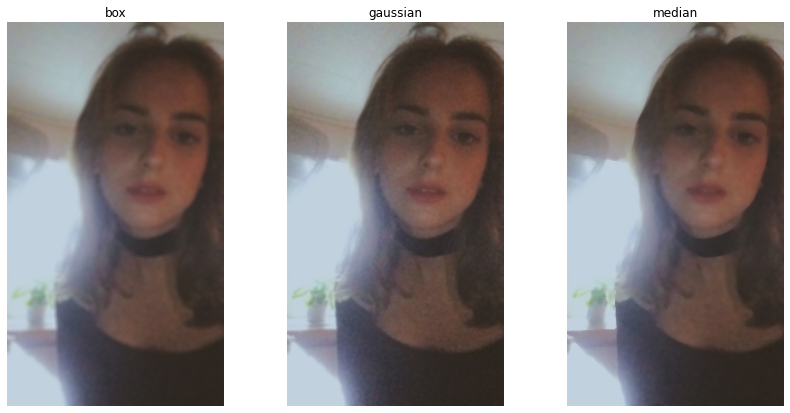

In [7]:
display_multiple_inline([img_blur, img_blur_gaus, img_blur_med], 3, img_titles=['box', 'gaussian', 'median'], base_sizes=(4,6))

#### **Задание 2. Усиление резкости методом Unsharp Masking**
1. Выбрать изображение с множеством мелких деталей (текстуры, тонкие линии).  
2. Выполнить гауссовое размытие (например, с ядром 7×7 и \(\sigma\approx2\)).  
3. Реализовать формулу Unsharp Masking: \(\displaystyle I_{\text{sharpened}} = I + \alpha \,(I - I_{\text{blurred}})\), перебирая несколько значений \(\alpha\) (0.5, 1.0, 1.5, 2.0).  
4. Сравнить полученные результаты и отметить появление «ореолов» или артефактов при больших \(\alpha\).

In [8]:
path = 'example2.jpg'
img2 = cv2.imread(path)
img2 = scaler(img2, 4)

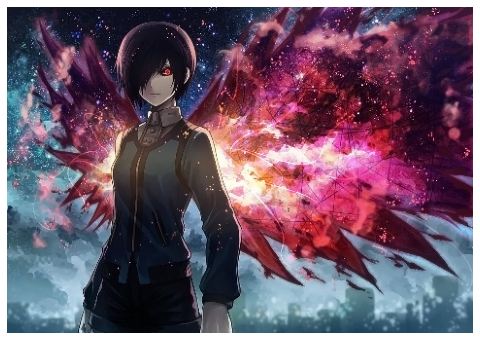

In [9]:
display_inline(img2)

In [10]:
img2_gaus = cv2.GaussianBlur(img2, (7,7), (2))
img2_substract_gaus = np.where(img2 > img2_gaus, img2 - img2_gaus, 0)

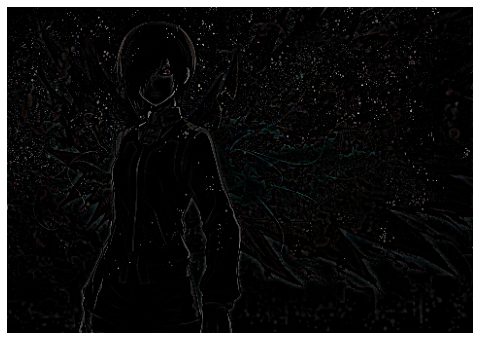

In [11]:
display_inline(img2_substract_gaus)

In [12]:
alphas = [0.5, 1.0, 1.5, 2.0]
num_images = len(alphas)
images = np.empty((num_images, *img2.shape), dtype=np.float32) 

for i, alpha in enumerate(alphas):
    cur_img = np.where(img2 + img2_substract_gaus * alpha <= 255, img2 + img2_substract_gaus * alpha, 255) # without this we get darker image
    cur_img = (cur_img - cur_img.min()) / (cur_img.max() - cur_img.min())
    images[i] = cur_img

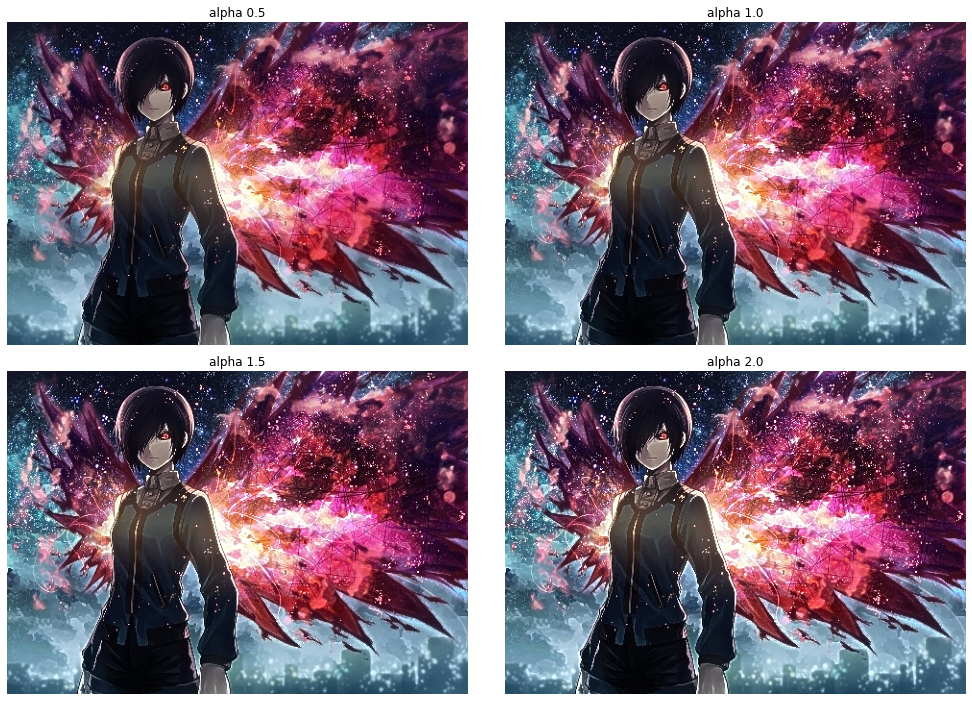

In [13]:
display_multiple_inline(images, 2, img_titles=[f'alpha {x}' for x in alphas], base_sizes=(7,5))

#### **Задание 3. Адаптивная пороговая сегментация и морфология**
1. Считать изображение, имеющее неравномерное освещение (например, скан документа с тенями).  
2. Преобразовать в оттенки серого и применить адаптивную пороговую обработку (`cv2.adaptiveThreshold`) с методами `MEAN_C` и `GAUSSIAN_C`.  
3. Полученную бинарную маску очистить морфологической операцией **opening** (эрозия → дилатация) для удаления белых шумовых точек.  
4. Сравнить исходные двоичные изображения и те, что прошли морфологическую очистку. Обсудить, насколько улучшилось качество сегментации.

In [14]:
path = 'example3.jpg'
img3 = cv2.imread(path)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
img3_blur = cv2.GaussianBlur(img3, (5,5), 0)

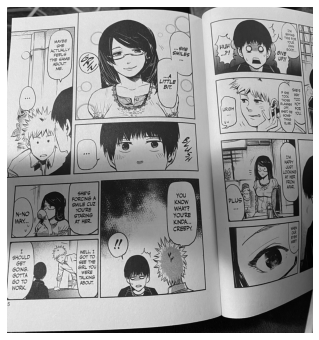

In [15]:
display_inline(img3)

In [16]:
img3_adapt_mean = cv2.adaptiveThreshold(img3,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,31,20)
img3_adapt_gaus = cv2.adaptiveThreshold(img3,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,31,20)

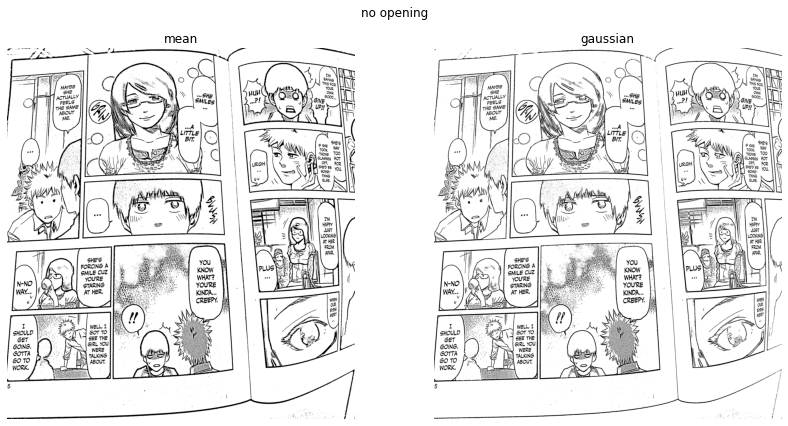

In [17]:
display_multiple_inline([img3_adapt_mean, img3_adapt_gaus], 2, img_titles=['mean', 'gaussian'], title='no opening', base_sizes=(6,6))

In [18]:
kernel = np.ones((5,5), np.uint8)
img3_adapt_mean_open = cv2.dilate(cv2.erode(img3_adapt_mean, kernel), kernel)
img3_adapt_gaus_open = cv2.dilate(cv2.erode(img3_adapt_gaus, kernel), kernel)

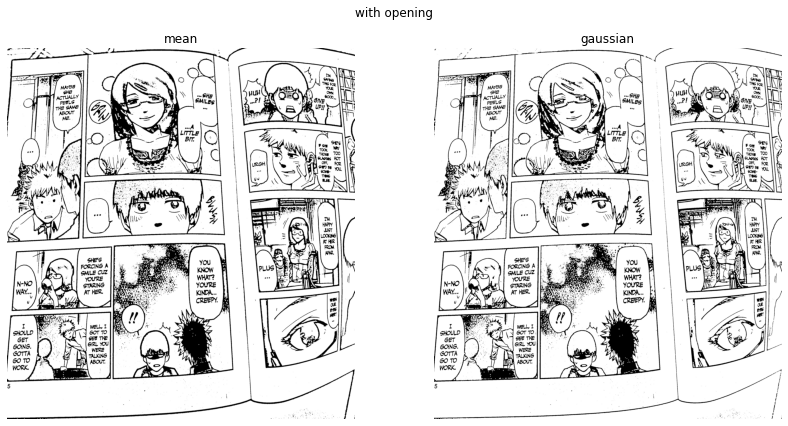

In [19]:
display_multiple_inline([img3_adapt_mean_open, img3_adapt_gaus_open], 2, img_titles=['mean', 'gaussian'], title='with opening', base_sizes=(6,6))

#### **Задание 4. Устранение шума «соль и перец» с помощью медианного фильтра и морфологии**
1. Искуственно добавить к выбранному изображению шум типа «соль и перец» (заменив случайные пиксели на 0 и 255).  
2. Применить медианный фильтр (`cv2.medianBlur`) с ядрами 3×3, 5×5, 7×7 и сравнить результаты.  
3. Преобразовать изображение в бинарное (пороговая сегментация) и попробовать удалить шумовые точки с помощью морфологического **открытия** (разные размеры ядра).  
4. Сравнить оба подхода (чисто медианная фильтрация vs. морфология) и сделать выводы о достоинствах и недостатках каждого в разных сценариях.

In [20]:
from tools import get_noised_image

In [21]:
path = 'example4.webp'
img4 = cv2.imread(path)

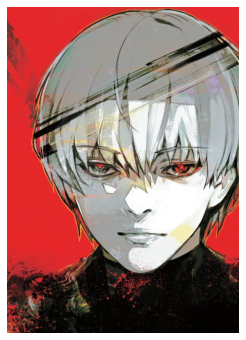

In [22]:
display_inline(img4)

In [23]:
img4_noised = get_noised_image(img4, sp=True)

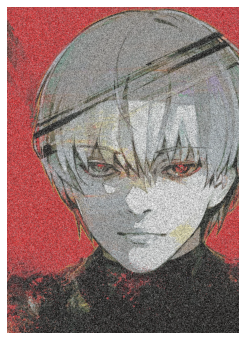

In [24]:
display_inline(img4_noised)

In [25]:
def apply_median_blur(img, kernel):
    return cv2.medianBlur(img, kernel)

In [26]:
from tools import iterative_filter

In [ ]:
kernels = [3, 5, 7]
params = [{"kernel": k} for k in kernels]

img4_blurred = iterative_filter(img4_noised, params, apply_median_blur)

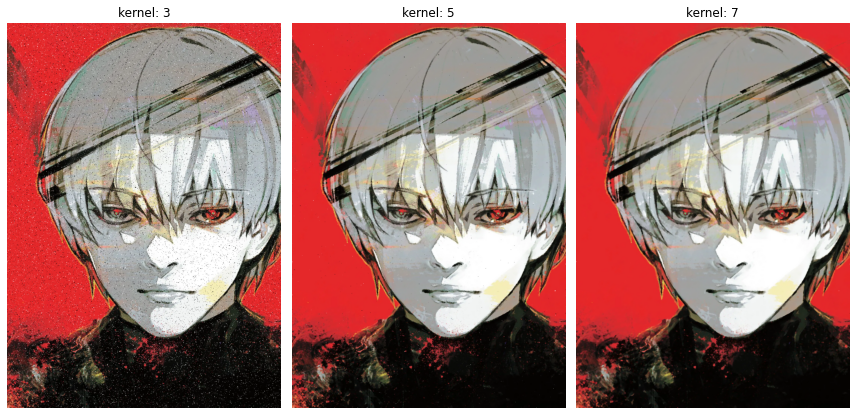

In [34]:
display_multiple_inline(img4_blurred, cols=len(kernels), base_sizes=(4,6), img_titles=[f'kernel: {k}' for k in kernels])

In [46]:
def open_image(img, params):
    erode_params = params['erode_params']
    dilate_params = params['dilate_params']
    return cv2.dilate(cv2.erode(img, **erode_params), **dilate_params)

In [47]:
kernels = [np.ones((i,i), np.uint8) for i in [3, 5, 7]]
iterations = list(range(5))

combinations = []
for kernel in kernels:
    for iteration in iterations:
        combinations.append({
                      'erode_params': {'kernel': kernel, 'iterations': iteration},
                      'dilate_params': {'kernel': kernel, 'iterations': iteration}
                 })

In [50]:
img4_blurred = iterative_filter(img4_noised, combinations, open_image)

TypeError: open_image() got an unexpected keyword argument 'erode_params'

In [51]:
combinations

[{'erode_params': {'kernel': array([[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]], dtype=uint8),
   'iterations': 0},
  'dilate_params': {'kernel': array([[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]], dtype=uint8),
   'iterations': 0}},
 {'erode_params': {'kernel': array([[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]], dtype=uint8),
   'iterations': 1},
  'dilate_params': {'kernel': array([[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]], dtype=uint8),
   'iterations': 1}},
 {'erode_params': {'kernel': array([[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]], dtype=uint8),
   'iterations': 2},
  'dilate_params': {'kernel': array([[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]], dtype=uint8),
   'iterations': 2}},
 {'erode_params': {'kernel': array([[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]], dtype=uint8),
   'iterations': 3},
  'dilate_params': {'kernel': array([[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]], dtype=uint8),
   'iterations